In [1]:
library(readxl)
library(data.table)
library(ggplot2)
library(ggprism)
library(ggforce)
library(ggetho)
library(ggsignif)
library(zoo)
theme_set(theme_prism(base_size=20))
options(repr.plot.width=15, repr.plot.height=15)
source("R/plot.R")
source("R/Cbind.R")
source("R/link_idoc_metadata.R")
source("R/library.R")


Loading required package: behavr


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




This notebook reads the IDOC results stored in "IDOC_METHODS_PAPER_METADATA.xlsx" and produces a csv file with the data in tidy format

* Fly_group_experiment_treatment: experimental information of the fly 
* fly_name_reference: unique animal identifier, built as follows: date_time(scientist_suffix)_ROI_X
* experiment: type of memory evaluated (20min STM, 1h STM, LTM, LTM CHX, ...)
* id
* test: (PI is read PRE or POST conditioning)
* PI: (value of PI)
* Training_session: how many times CS-US pairing is presented
* Genotype: genotype of the fly
* interval: NONE, or ZTX-ZTY if the fly was SD'd between ZT X and ZT Y
* ZT4,ZT4.5,ZT5,ZT5.5,ZT6,ZT6.5,ZT7,ZT7.5,ZT8,ZT8.5,ZT9,ZT9.5,ZT10,ZT10.5,ZT11,ZT11.5,ZT12,ZT12.5,ZT13,ZT13.5,ZT14,ZT14.5,ZT15,ZT15.5,ZT16,ZT16.5,ZT17,ZT17.5,ZT18,ZT18.5,ZT19,ZT19.5,ZT20,ZT20.5,ZT21,ZT21.5,ZT22,ZT22.5,ZT23,ZT23.5,ZT24,ZT24.5,ZT25,ZT25.5,ZT26,ZT26.5,ZT27,ZT27.5,ZT28,ZT28.5,ZT29,ZT29.5,ZT30
* ZT4_interactions,ZT4.5_interactions,ZT5_interactions,ZT5.5_interactions,ZT6_interactions,ZT6.5_interactions,ZT7_interactions,ZT7.5_interactions,ZT8_interactions,ZT8.5_interactions,ZT9_interactions,ZT9.5_interactions,ZT10_interactions,ZT10.5_interactions,ZT11_interactions,ZT11.5_interactions,ZT12_interactions,ZT12.5_interactions,ZT13_interactions,ZT13.5_interactions,ZT14_interactions,ZT14.5_interactions,ZT15_interactions,ZT15.5_interactions,ZT16_interactions,ZT16.5_interactions,ZT17_interactions,ZT17.5_interactions,ZT18_interactions,ZT18.5_interactions,ZT19_interactions,ZT19.5_interactions,ZT20_interactions,ZT20.5_interactions,ZT21_interactions,ZT21.5_interactions,ZT22_interactions,ZT22.5_interactions,ZT23_interactions,ZT23.5_interactions,ZT24_interactions,ZT24.5_interactions,ZT25_interactions,ZT25.5_interactions,ZT26_interactions,ZT26.5_interactions,ZT27_interactions,ZT27.5_interactions,ZT28_interactions,ZT28.5_interactions,ZT29_interactions,ZT29.5_interactions,ZT30_interactions
User


In [2]:
database <- "IDOC_metadata_AOJ - metadata.csv"
metadata_aoj <- data.table::fread(database)[fly_name_reference != "" & comment=="OK",]
tail(metadata_aoj)


row_id,fly_name_reference,region_id,date,machine_name,incubator,tube,motor,schedule,SD_quality,⋯,User,experiment,PRE_1,PRE_2,PRE,POST_1,POST_2,POST,ITO chamber set,non-ITO chamber set
<int>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,⋯,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>
335,2024-08-29_15-51-50_AOJ_ET_ROI_15,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40
336,2024-08-29_15-51-50_AOJ_ET_ROI_16,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40
337,2024-08-29_15-51-50_AOJ_ET_ROI_17,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40
338,2024-08-29_15-51-50_AOJ_ET_ROI_18,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40
339,2024-08-29_15-51-50_AOJ_ET_ROI_19,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40
340,2024-08-29_15-51-50_AOJ_ET_ROI_20,NA,NA,NA,NA,NA,NA,NA,NONE,⋯,AOJ,20min STM (sucrose tube),NA,NA,NA,NA,NA,NA,1-20,21-40


In [3]:
database <- "/idoc_data/paper/CHuiData.ods"
sheets <- readODS::list_ods_sheets(database)
columns <- c(
    "Files", "Genotype", "ROI", "Gender", "Age", "ATR", "Training",
    "Odor", "Sugar", "Electric shock",  "PRE", "PRE_1", "PRE_2", "POST", "POST_1", "POST_2", "Keep",
    "fly_name_reference", "experiment"
)
metadata_ch <- read_idoc_metadata(file = database, sheets=sheets, columns = columns, backend=readODS::read_ods)
metadata_ch$SD_quality <- "NONE"
metadata_ch$SD_quality_second_eye <- "NONE"
metadata_ch$interactor_time_window <- "NONE"
metadata_ch$interactor <- "No_stimulator"
metadata_ch$`comment on SD` <- NA
metadata_ch$User <- "CH"
metadata_ch$region_id <- "NONE"

In [4]:
# metadata_ch$POST

In [5]:
database <- "idoc_metadata.ods"
sheets <- c("20min_STM", "1hr_STM", "3hr_STM")
columns <- c(
    "Files", "Genotype", "ROI", "User", "fly_name_reference", "Gender", "Age", "ATR", "Training",
    "Odor", "Sugar", "Electric shock",  "PRE", "PRE_1", "PRE_2", "POST", "POST_1", "POST_2", "Keep",
    "SD_quality", "SD_quality_second_eye", "interactor_time_window", "interactor", "comment on SD", "experiment"
)

## Read STM experiments

In [6]:
metadata_stm <- read_idoc_metadata(file = database, sheets=sheets, columns = columns, backend=readODS::read_ods)
# STM flies don't go to the ethoscope, so region_id is NONE
metadata_stm$region_id <- "NONE"

Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 82 103 124 145 166 rows from metadata”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 rows from metadata”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 21 42 63 84 105 126 rows from metadata”


In [7]:
metadata_ltm <- read_idoc_metadata(file = database, sheets=c("24hr_LTM"), columns = c(columns, "region_id"), backend=readODS::read_ods)
# keep either NS or good SD flies, (discard bad SD flies) 
metadata_ltm <- metadata_ltm[SD_quality %in% c("No_sleep_depriver", "good") & SD_quality_second_eye %in% c("No_sleep_depriver", "good"),]
metadata_ltm[SD_quality=="No_sleep_depriver", SD_quality := "NONE"]
metadata_ltm[SD_quality_second_eye=="No_sleep_depriver", SD_quality_second_eye := "NONE"]


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 20 38 58 79 100 117 128 139 150 161 172 183 194 205 216 227 238 249 259 270 281 292 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 357 368 379 390 401 rows from metadata”


In [8]:
metadata_gtacr <- read_idoc_metadata(file = database, sheets=c("24hr_LTM_GTACR"), columns =  c(columns, "region_id"), backend=readODS::read_ods)
metadata_gtacr[SD_quality=="No_sleep_depriver", SD_quality := "NONE"]
metadata_gtacr[SD_quality_second_eye=="No_sleep_depriver", SD_quality_second_eye := "NONE"]


Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“NAs introduced by coercion”
Warning message in doTryCatch(return(expr), name, parentenv, handler):
“Deleting 11 22 33 44 55 66 rows from metadata”


In [9]:
metadata <- rbind(
    metadata_stm[, .(fly_name_reference, Files, ROI, Genotype, Gender, Age, interactor, interactor_time_window, SD_quality, SD_quality_second_eye, `comment on SD`, User, region_id, experiment, PRE_1, PRE_2, PRE, POST_1, POST_2, POST)],
    metadata_ltm[, .(fly_name_reference, Files, ROI, Genotype, Gender, Age, interactor, interactor_time_window, SD_quality, SD_quality_second_eye, `comment on SD`, User, region_id, experiment, PRE_1, PRE_2, PRE, POST_1, POST_2, POST)],
    metadata_gtacr[, .(fly_name_reference, Files, ROI, Genotype, Gender, Age, interactor, interactor_time_window, SD_quality, SD_quality_second_eye, `comment on SD`, User, region_id, experiment, PRE_1, PRE_2, PRE, POST_1, POST_2, POST)],
    metadata_ch[, .(fly_name_reference, Files, ROI, Genotype, Gender, Age, interactor, interactor_time_window, SD_quality, SD_quality_second_eye, `comment on SD`, User, region_id, experiment, PRE_1, PRE_2, PRE, POST_1, POST_2, POST)],
    metadata_aoj[, .(fly_name_reference, Files, ROI, Genotype, Gender, Age, interactor, interactor_time_window, SD_quality, SD_quality_second_eye, `comment on SD`="NONE", User, region_id, experiment, PRE_1, PRE_2, PRE, POST_1, POST_2, POST)]
)

In [10]:
metadata_linked <- link_idoc_metadata(metadata, result_dir="/idoc_data/IDOC", verbose=FALSE)
n_missing_animals <- nrow(metadata_linked[is.na(idoc_folder),])
if (n_missing_animals>0) {
    warning(paste(n_missing_animals, "animals could not be linked"))
}

In [11]:
metadata_linked <- metadata_linked[!is.na(idoc_folder),]
metadata_linked[, PRE_manual := PRE]
metadata_linked[, POST_manual := POST]

In [12]:
# use raw csv
source("R/library.R")
data_raw <- load_idoc_data(
    # metadata_linked,#[Files=="2024-08-27_14-13-07_AOJ_ET",],#[Files=="2024-07-22_15-42-18_ET_AOJ_TEST",],
    # metadata_linked[Files=="2024-08-27_15-35-18_AOJ_ET",],#[Files=="2024-07-22_15-42-18_ET_AOJ_TEST",],
    # metadata_linked[Files=="2023-07-04_13-45-39(ET_3h)", ],
    metadata_linked,
    # how many exits need to happen for the trial to be considered?
    min_exits=3,
    # load from trial 1 and trial 2, applying the min_exit requirement to each separately
    trials=1:2
)
# use chui annotation in excel file
# data <- data.table::copy(metadata_linked)

[1] "/idoc_data/IDOC/2021-11-idoc_data/2021-11-03 (CH1)/2021-11-04_07-50-52/POST_1_7mm/2021-11-04_07-50-52_7eb8e224bdb944a68825986bc70de6b1_PI_POST_1_7mm.csv"
   region_id aversive appetitive preference_index
1:         1        6          0       -1.0000000
2:         2        3          3        0.0000000
3:         3        0          3        1.0000000
4:         4        0          1               NA
5:         5        3          3        0.0000000
6:         6        1          0               NA
7:         7        4          1       -0.6000000
8:         8        3          5        0.2500000
9:         9        3          4        0.1428571
[1] "/idoc_data/IDOC/2021-11-idoc_data/2021-11-03 (CH1)/2021-11-04_07-50-52/POST_2_7mm/2021-11-04_07-50-52_7eb8e224bdb944a68825986bc70de6b1_PI_POST_2_7mm.csv"
   region_id aversive appetitive preference_index
1:         1        4          0       -1.0000000
2:         2        2          3        0.2000000
3:         3        3          2

In [13]:
missing_data <- data_raw[is.na(PRE_1)&is.na(POST_1), .(.N, Files, ROI, experiment, PRE_1, POST_1), by=Files][, .SD[1], by=Files]
nrow(missing_data)

[1] 83

In [14]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
missing_data

Files,N,ROI,experiment,PRE_1,POST_1
<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>
2021-09-30 (CH),20,1,20min STM,NA,NA
2021-09-30 (CH1),20,1,20min STM,NA,NA
2021-10-01 (CH),20,1,20min STM,NA,NA
2021-10-01 (CH1),20,1,20min STM,NA,NA
2021-10-01 (CH2),20,1,20min STM,NA,NA
2021-10-02 (CH),20,1,20min STM,NA,NA
2021-10-02 (CH1),20,1,20min STM,NA,NA
2021-10-03 (CH),20,1,20min STM unpaired,NA,NA
2021-10-03 (CH1),20,1,20min STM unpaired,NA,NA


In [29]:
data_raw[,PRE_machine := PRE]
data_raw[,PRE_1_machine := PRE_1]
data_raw[,PRE_2_machine := PRE_2]
data_raw[,POST_machine := POST]
data_raw[,POST_1_machine := POST_1]
data_raw[,POST_2_machine := POST_2]
data_raw[,.(Files, ROI, experiment, POST_1_machine, POST_2_machine, POST_1_manual, POST_2_manual, POST_manual, POST_machine, diff=POST_manual-POST_machine)]

Files,ROI,experiment,POST_1_machine,POST_2_machine,POST_1_manual,POST_2_manual,POST_manual,POST_machine,diff
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2021-09-30 (CH),1,20min STM,NA,NA,NA,NA,NA,NA,NA
2021-09-30 (CH),2,20min STM,NA,NA,NA,NA,NA,NA,NA
2021-09-30 (CH),3,20min STM,NA,NA,0.33,-1,-0.335,NA,NA
2021-09-30 (CH),4,20min STM,NA,NA,-1,-0.67,-0.835,NA,NA
2021-09-30 (CH),5,20min STM,NA,NA,0.2,0.14,0.170,NA,NA
2021-09-30 (CH),6,20min STM,NA,NA,-0.33,-0.33,-0.330,NA,NA
2021-09-30 (CH),7,20min STM,NA,NA,-0.2,-0.33,-0.265,NA,NA
2021-09-30 (CH),8,20min STM,NA,NA,-0.5,NA,-0.500,NA,NA
2021-09-30 (CH),9,20min STM,NA,NA,0.33,0.33,0.330,NA,NA


In [13]:
hits <- data_raw[, .(Files, idoc_folder, User, PRE_found=sapply(PRE_files, function(x) {!any(is.na(x))}), POST_found=sapply(POST_files, function(x) {!any(is.na(x))}))]

In [14]:
data_raw[,PRE_machine := PRE]
data_raw[,PRE_1_machine := PRE_1]
data_raw[,PRE_2_machine := PRE_2]
data_raw[,POST_machine := POST]
data_raw[,POST_1_machine := POST_1]
data_raw[,POST_2_machine := POST_2]

In [15]:
# if you want to use the number that people wrote in their sheets
# data_raw[ , PRE := PRE_manual]
# data_raw[ , POST := POST_manual]
# data_raw[substr(Files, 1, 4)=="2024", PRE := PRE_machine]
# data_raw[substr(Files, 1, 4)=="2024", POST := POST_machine]
# if you want to use the number in the csv only
data_raw[ , PRE := PRE_machine]
data_raw[ , POST := POST_machine]



In [38]:
data_raw[, .(mean(abs(PRE_machine-PRE_manual)>0.01, na.rm = T))] 

V1
<dbl>
0.009463722


In [37]:
data_raw[, .(mean(abs(POST_machine-POST_manual)>0.01, na.rm = T))] 

V1
<dbl>
0.1787234


In [50]:
data_raw[Files=="2021-09-30 (CH)", .(ROI, PRE_machine, PRE_manual, POST_machine, POST_manual) ]
         

ROI,PRE_machine,PRE_manual,POST_machine,POST_manual
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,NA,NA,NA,NA
2,NA,-0.030,NA,NA
3,NA,NA,NA,-0.335
4,NA,0.000,NA,-0.835
5,NA,0.055,NA,0.170
6,NA,NA,NA,-0.330
7,NA,0.000,NA,-0.265
8,NA,-0.070,NA,-0.500
9,NA,-0.055,NA,0.330


In [55]:
data_raw[abs(POST_machine-POST_manual)>0.01, .(.N), by=.(Files, experiment)]

Files,experiment,N
<chr>,<chr>,<int>
2021-11-17 (CH),24hr LTM,5
2021-11-17 (CH1),24hr LTM,5
2023-06-13_15-41-34(ESB-GTACR2),24hr LTM GTACR,3
2023-06-22_15-37-53(ESB-GTACR2),24hr LTM GTACR,4
2023-06-27_16-34-26(ET_3h),3hr STM,1
2023-07-04_13-45-39(ET_3h),3hr STM,1
2023-07-11_15-51-12(ESB-GTACR2),24hr LTM GTACR,4
2023-07-23_16-20-43(ESB-massed),24hr LTM,5
2023-07-25_15-17-48(ESB-GTACR2),24hr LTM GTACR,3


In [80]:
data_raw[abs(POST_machine-POST_manual)>0.01, .(Files, ROI, experiment, POST_machine, POST_1, POST_2, POST_manual, diff=POST_manual-POST_machine), by=.(Files, experiment)]

ERROR: Error in .checkTypos(e, names_x): Object 'POST_machine' not found amongst Files, sheet, fly_name_reference, ROI, Genotype and 29 more


In [51]:
# data_raw[(!is.na(POST_manual)&is.na(POST_machine)), .(.N), by=.(Files, experiment)]

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 1467 rows containing missing values or values outside the scale range
(`geom_point()`).”


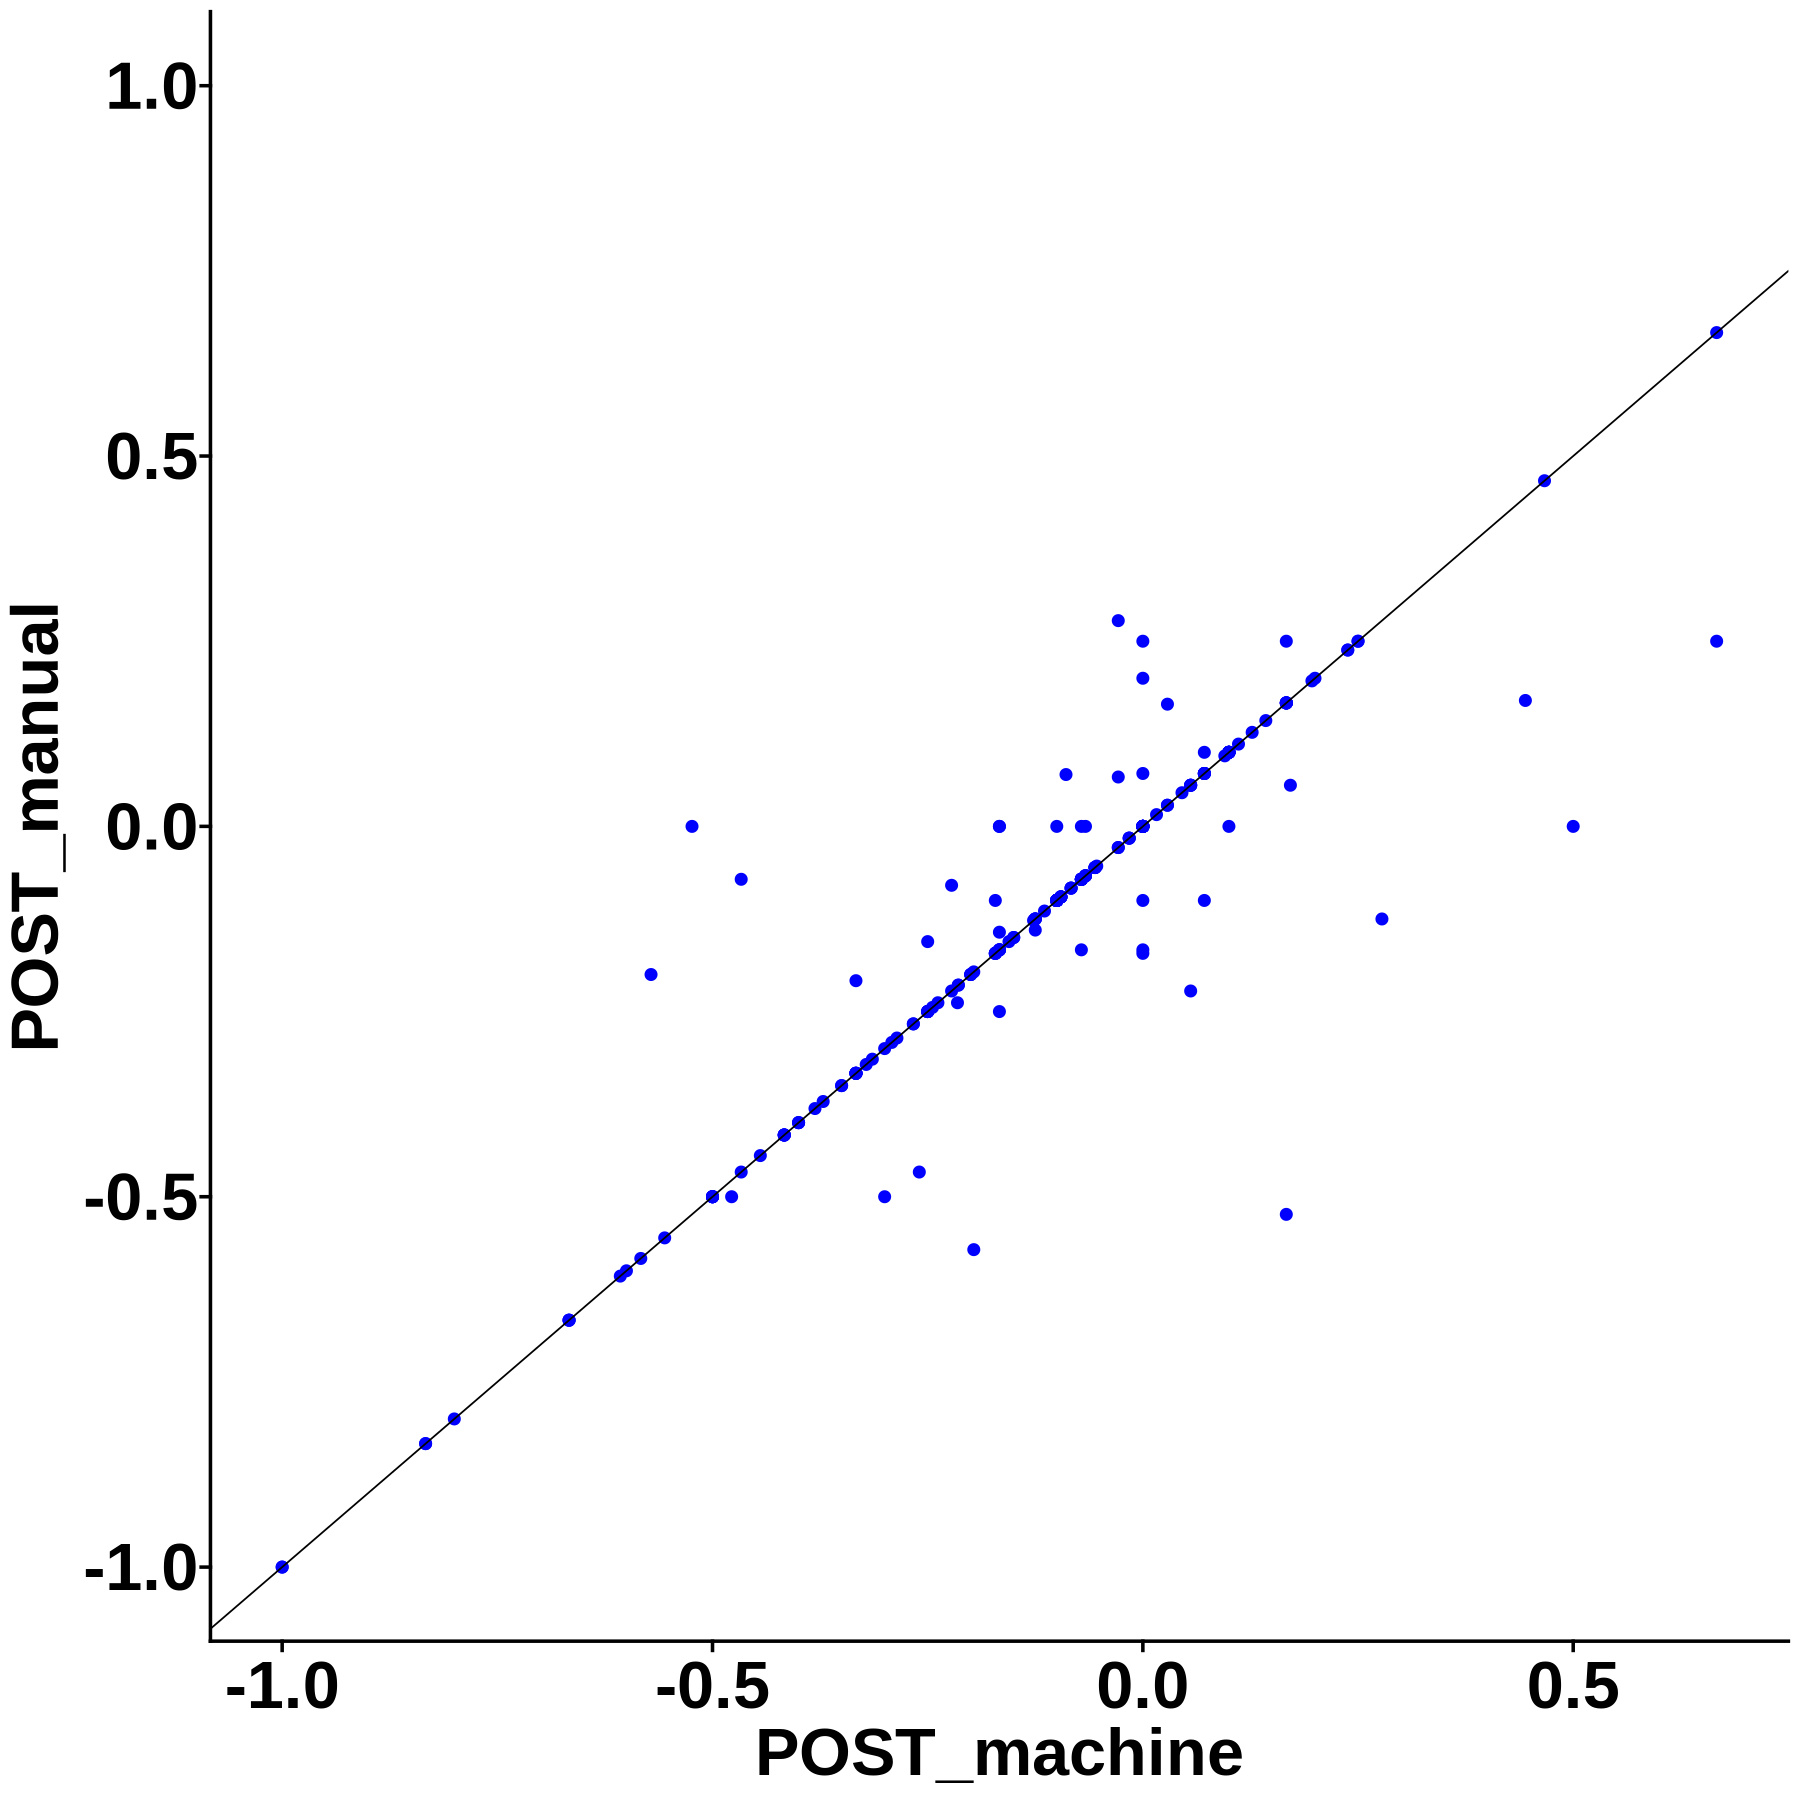

In [22]:
ggplot(
    data=data_raw,
    aes(x=POST_machine, y=POST_manual)
) +
    geom_point(color="blue", size=3) +
    geom_abline(intercept = 0, slope = 1)

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 1385 rows containing missing values or values outside the scale range
(`geom_point()`).”


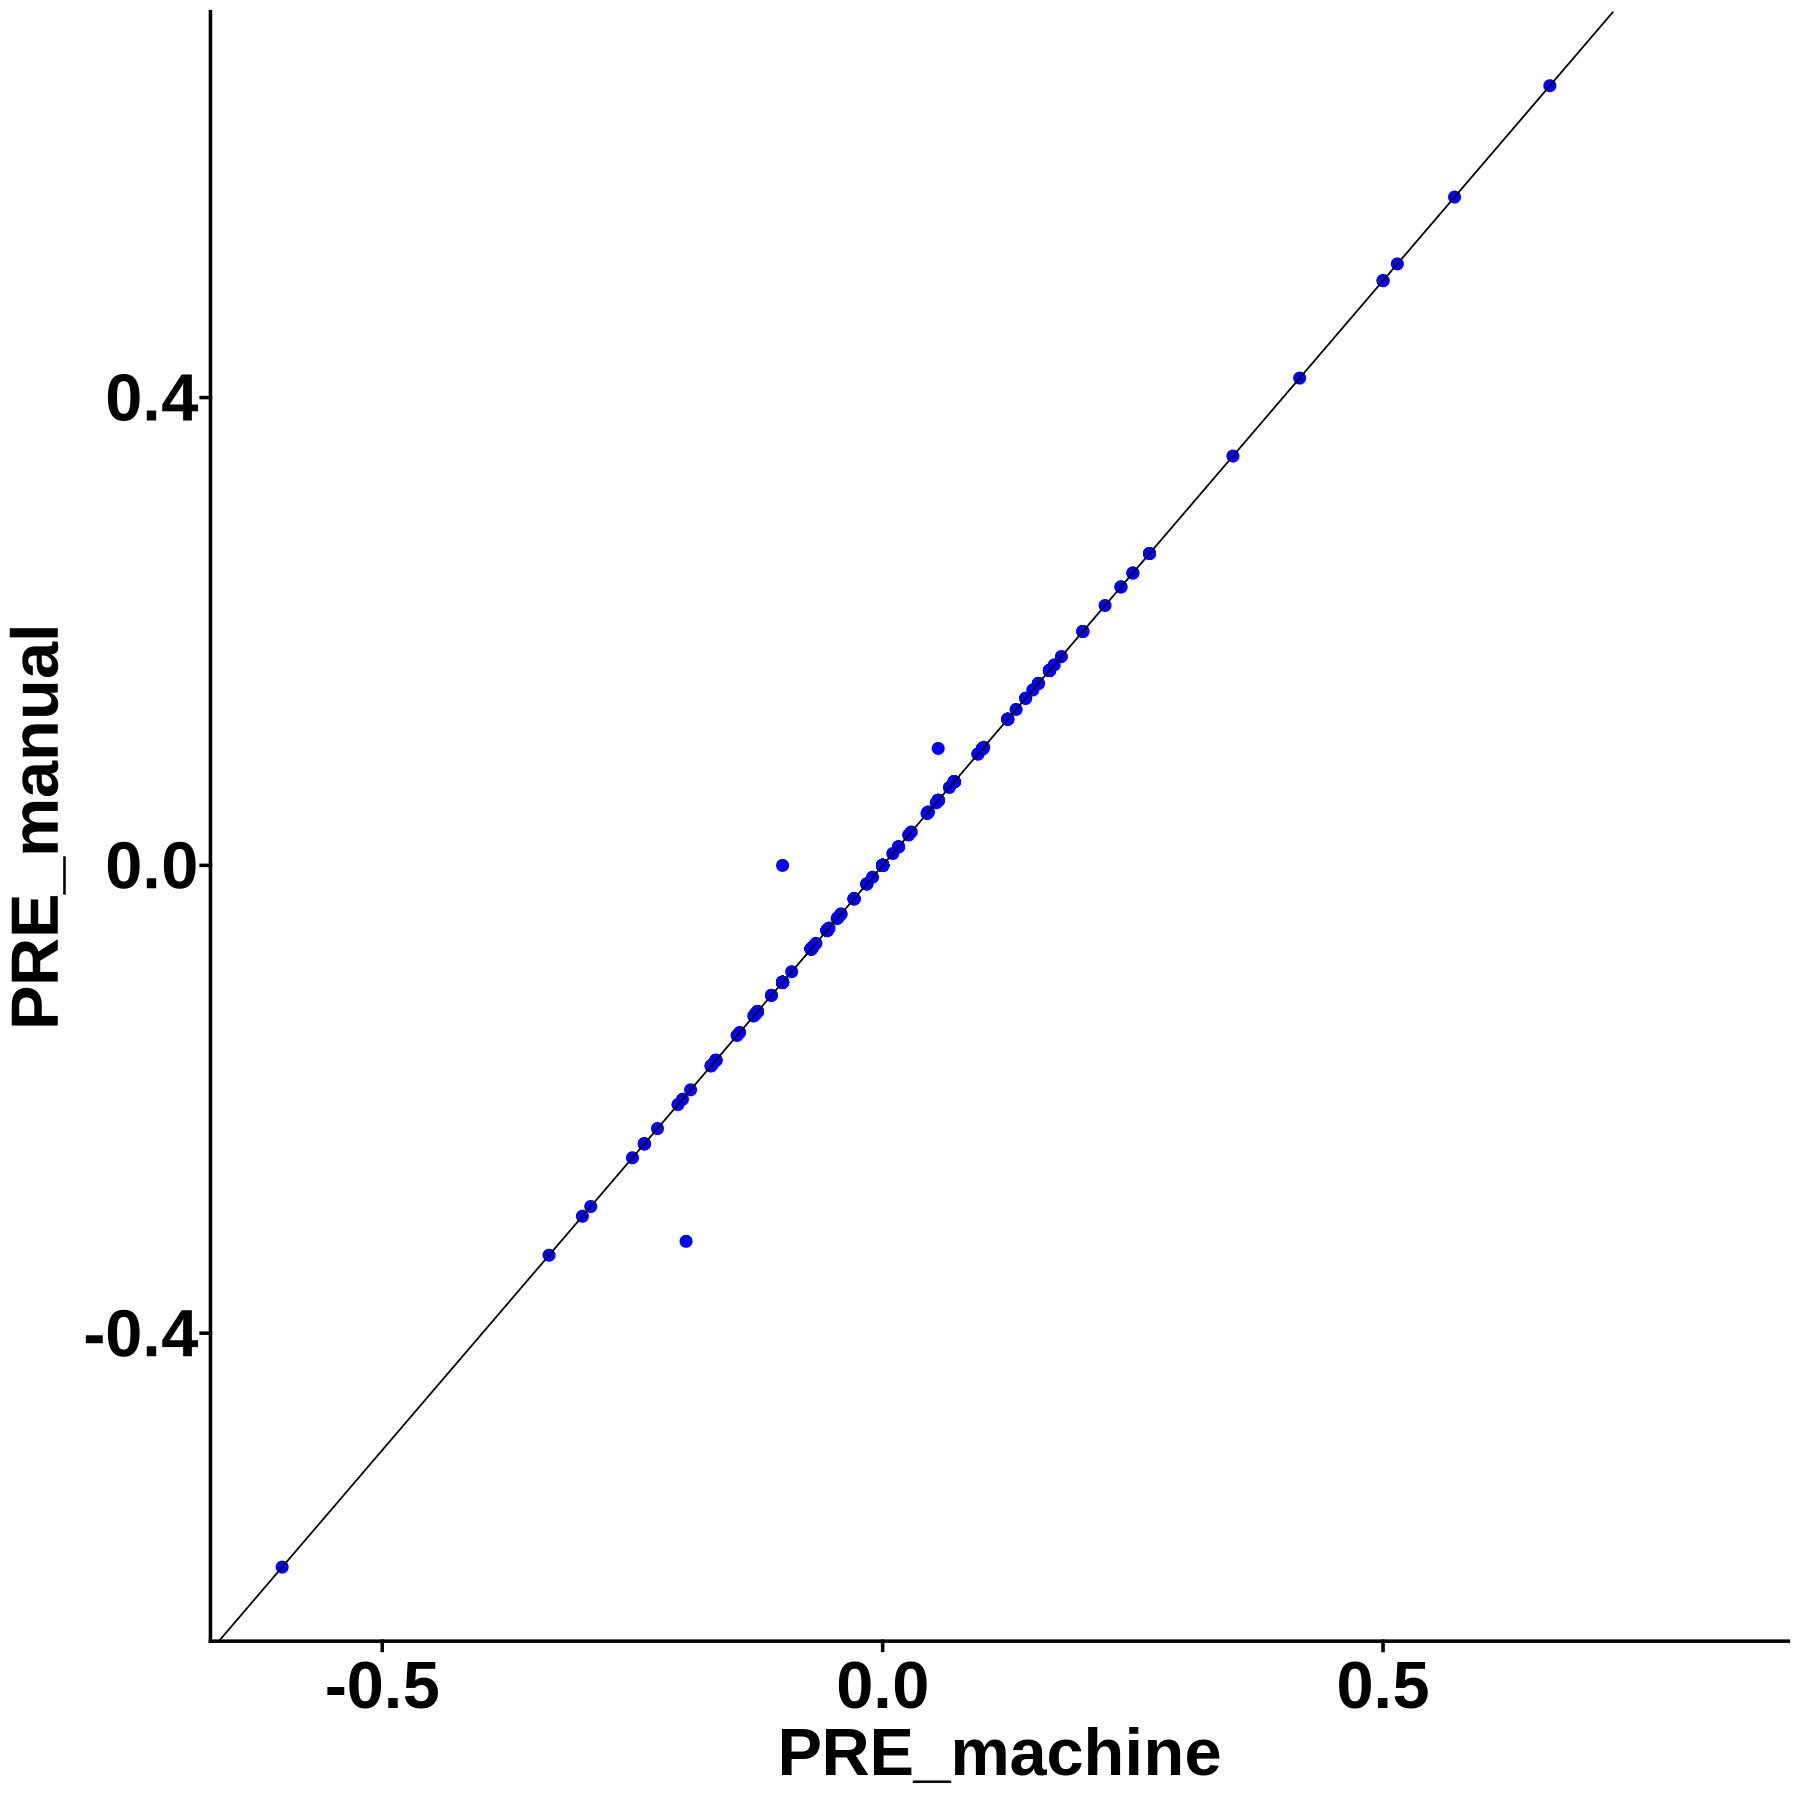

In [21]:
ggplot(
    data=data_raw,
    aes(x=PRE_machine, y=PRE_manual)
) +
    geom_point(color="blue", size=3) +
    geom_abline(intercept = 0, slope = 1)

In [42]:
# data_raw[, .N, by=Genotype]

In [43]:
# data_raw[Genotype=="dnc", .(Files, ROI, PRE, POST)]

In [44]:
data<-data_raw[!is.na(POST) & !is.na(PRE),]

In [45]:
# data_raw[Genotype=="orb2", .(Files, idoc_folder, sheet, PRE, POST)]

In [46]:
data<-data[abs(PRE)<=0.2,]

In [47]:
# verify there are not repeats (the same fly represent more than once)
counts <- data[, .N, by=fly_name_reference]
stopifnot(all(counts$N==1))

In [48]:
# format interactor time window so it is either NONE or one of the ZTs
data[interactor_time_window=="No_stimulator", interactor_time_window := "NONE"]
# generate the column SD_status to summarise SD_quality and SD_quality_second_eye
data[, SD_status := "NONE"]
data[interactor_time_window!="NONE" & !(SD_quality == "good" & SD_quality_second_eye == "good"), SD_status := "bad"]
data[SD_quality == "good" & SD_quality_second_eye == "good", SD_status := "good"]
# unknown = gtacr flies
data[SD_quality == "unknown" & SD_quality_second_eye == "unknown", SD_status := "unknown"]

data[ , interval := interactor_time_window]
data[ , interactor_time_window := NULL]



In [49]:
data[, .N ,by=.(interval, SD_quality, SD_quality_second_eye, SD_status)]

interval,SD_quality,SD_quality_second_eye,SD_status,N
<chr>,<chr>,<chr>,<chr>,<int>
NONE,NONE,NONE,NONE,596
ZT05-ZT11,unknown,unknown,unknown,47
ZT05-ZT24,good,good,good,12
ZT12-ZT18,good,good,good,25
ZT05-ZT11,good,good,good,26


In [50]:
data[, SD_quality := NULL]
data[, SD_quality_second_eye := NULL]

In [51]:
data[, id := 1:.N]


In [52]:
# table(data$User)
data[substr(fly_name_reference, 1, 7)%in% c("2024-07", "2024-08"),][, .N, by=Files]

Files,N
<chr>,<int>
2024-08-12_16-04-29_AOJ,1
2024-08-21_14-41-00_AOJ_ET,8
2024-08-22_14-30-39_AOJ_ET,8
2024-08-26_14-49-57_AOJ,4
2024-08-27_14-13-07_AOJ_ET,1
2024-08-27_15-35-18_AOJ_ET,4
2024-08-28_14-15-46_AOJ_ET,12
2024-08-29_14-33-30_AOJ_ET,9
2024-08-29_15-51-50_AOJ_ET,7


In [53]:
data_long <- melt(data = data, measure.vars = c("PRE", "POST"), value.name = "PI", variable.name = "test")
data.table::fwrite(x = data_long, file = "tidy_data.csv")
data.table::fwrite(x = data, file = "tidy_data_wide.csv")


remove all flies that don't have a PRE and POST

Warning message in plot_theme(plot):
“The `legend.text.align` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `legend.title.align` theme element is not defined in the element hierarchy.”


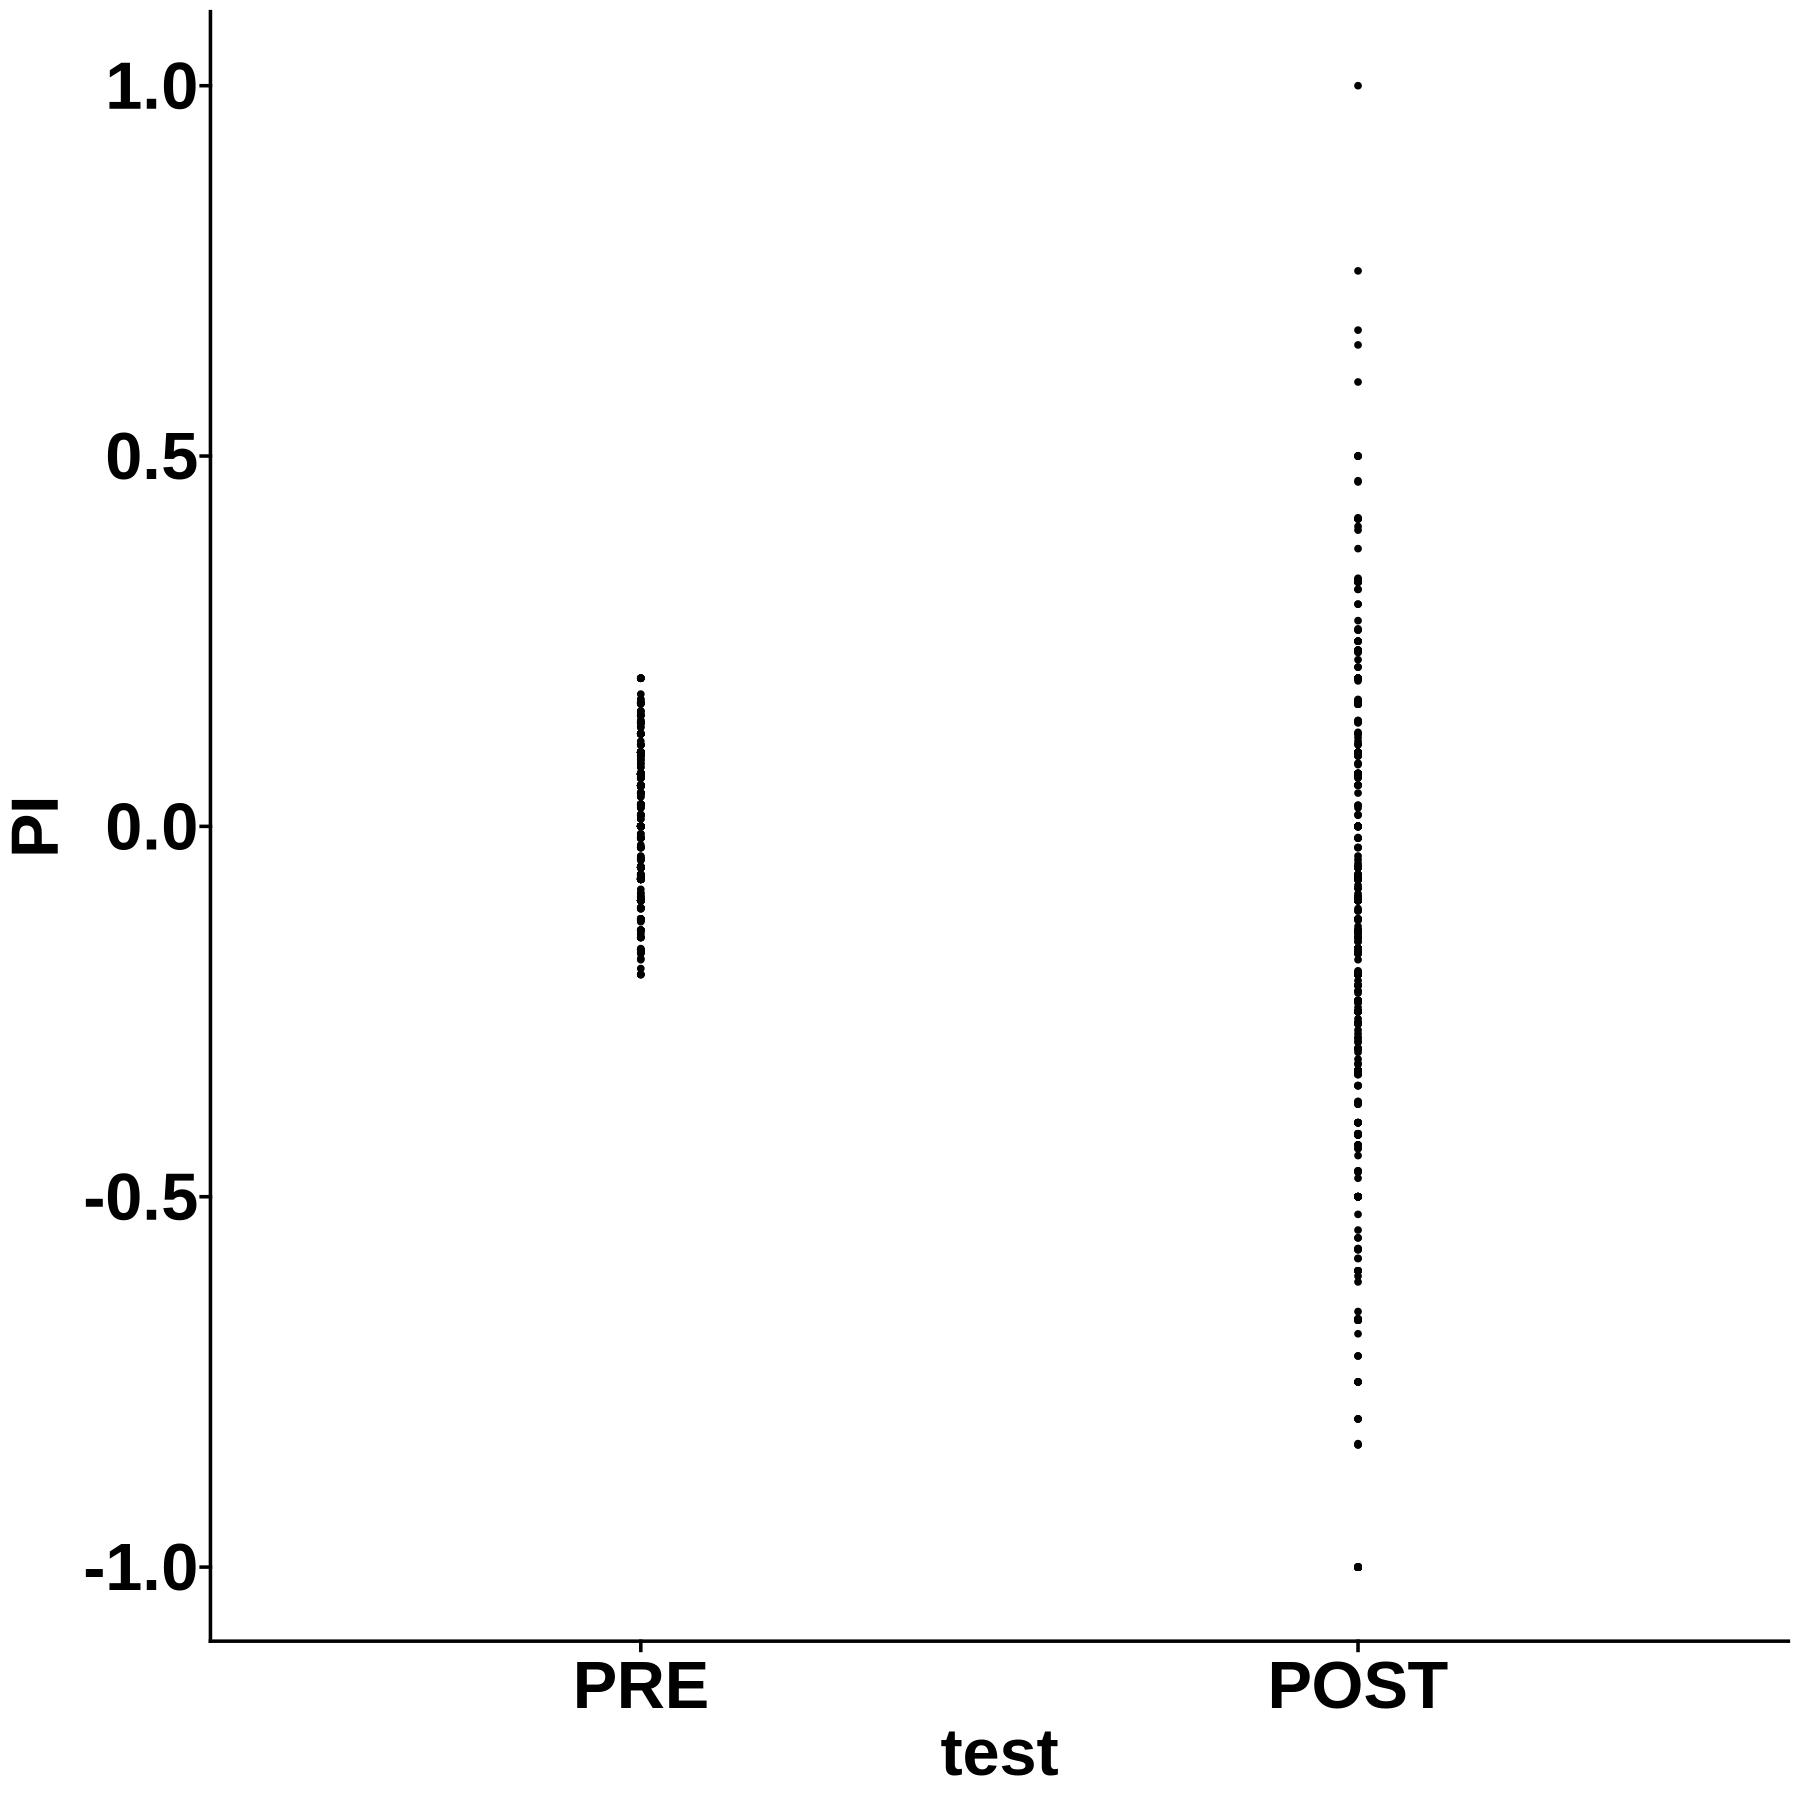

In [77]:
ggplot(data=data_long, aes(x=test, y=PI)) + geom_point()

In [ ]:
# data[, .(Files, idoc_folder, sheet, ROI, PRE, PRE_1, PRE_1_manual, PRE_2, PRE_2_manual, POST_1, POST_1_manual, POST_2, POST_2_manual)]
# data[Genotype=="orb2", .N, by=experiment]
# data(metadata_linked$interactor_time_window)
# hits[, .N, by=.(PRE_found, User)][order(PRE_found),]
# hits[, .N, by=.(POST_found, User)][order(POST_found),]
# metadata_linked[Training=="6X_Spaced" & interactor_time_window=="No_stimulator" & region_id != "NONE" & !is.na(PRE) & !is.na(POST)]
# table(metadata_linked$region_id)
# data[Genotype=="orb2", .N, by=experiment]